# Scikit-learn 

Can we predict the amount of power required to cool a house given the outdoor temperature and the current air_temperature?

In [1]:
import json
import pandas as pd

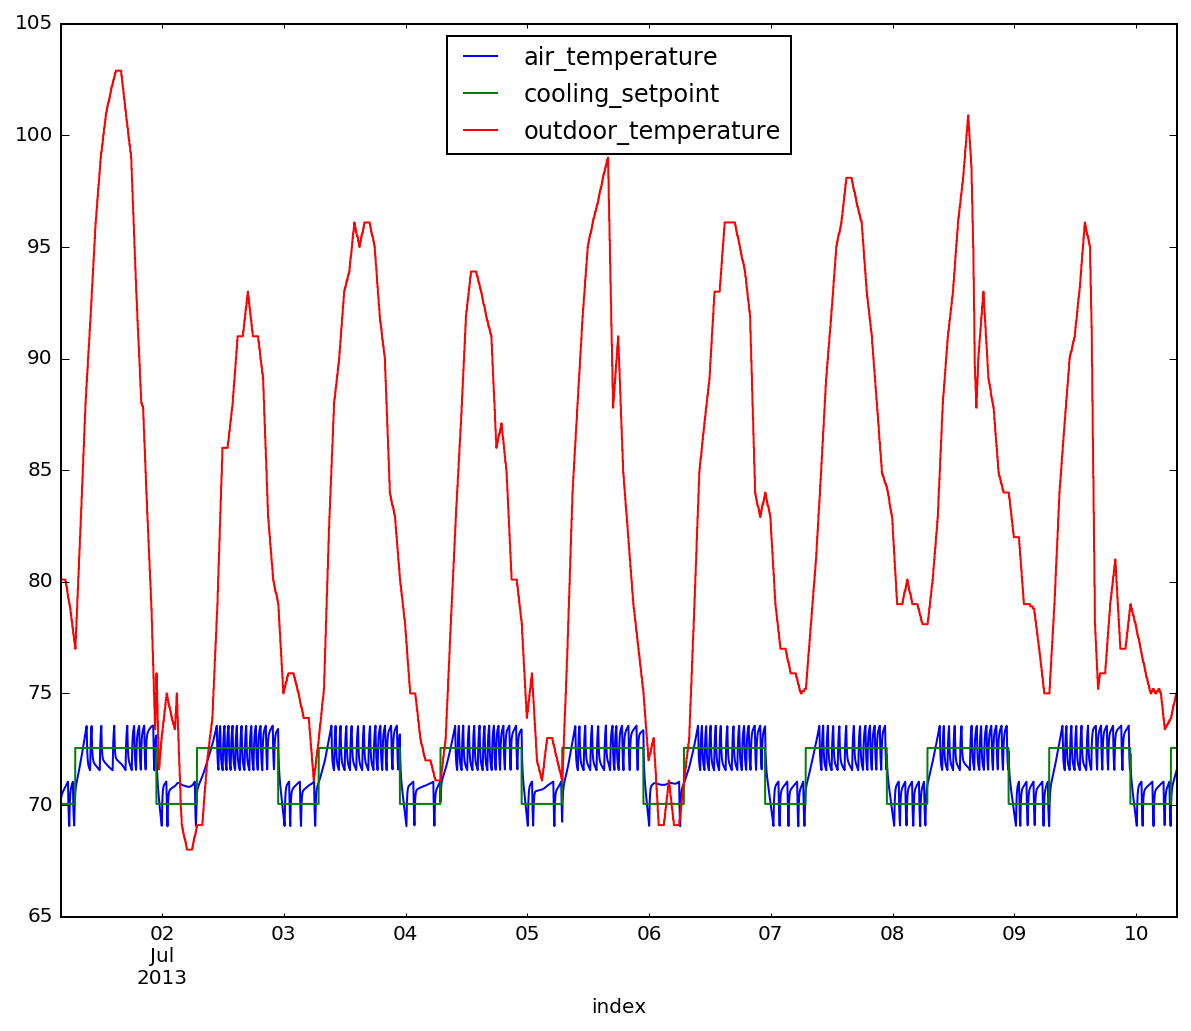

In [2]:
data = json.loads(open("data/itemc_house_0.json").read())

df = pd.DataFrame(data['timeseries'])
df['index'] = pd.to_datetime(df['index'])
df.set_index('index', inplace=True)

df[['air_temperature','cooling_setpoint', 'outdoor_temperature']].plot()

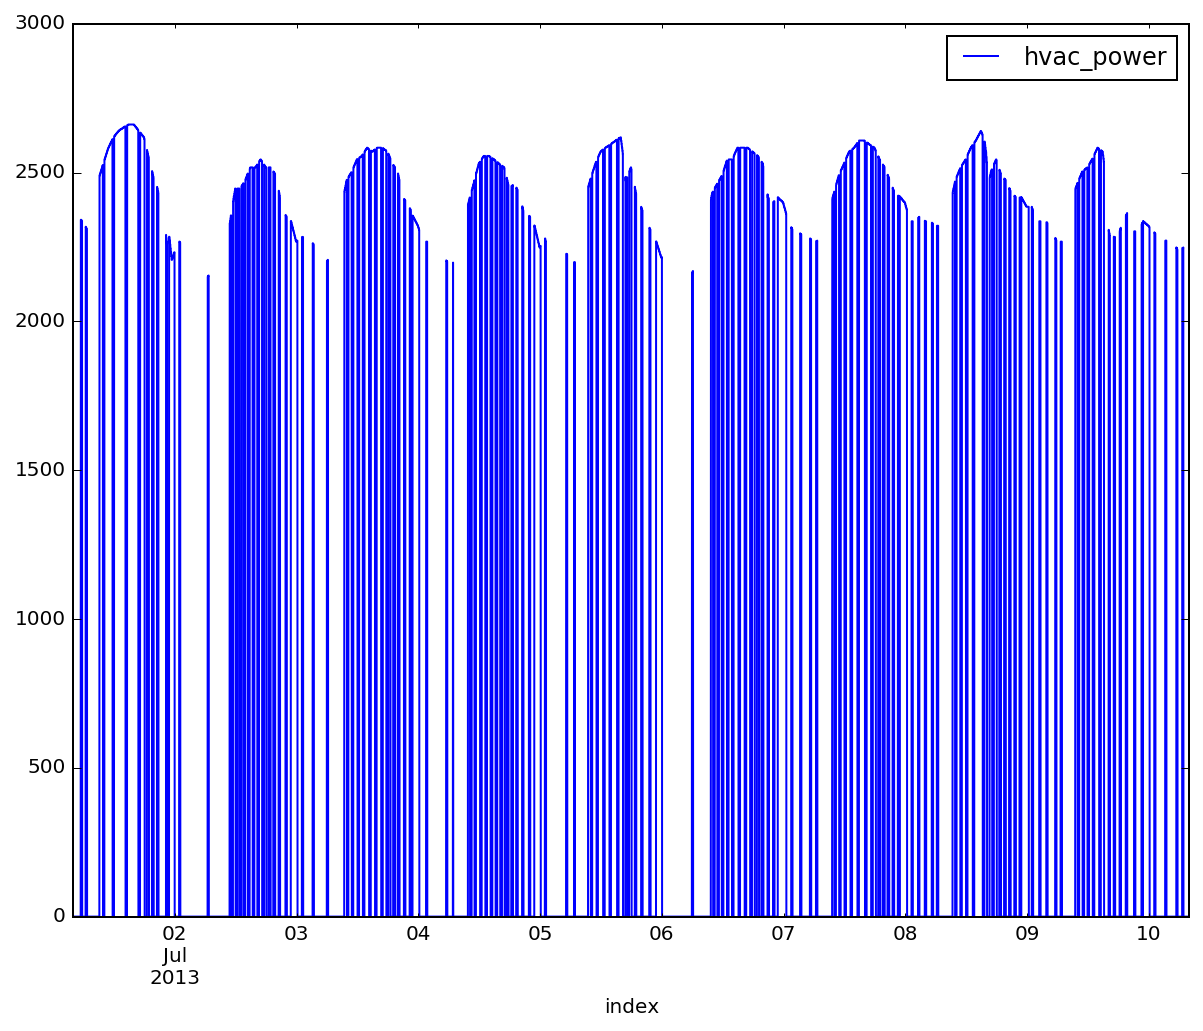

In [3]:
df[['hvac_power']].plot()

## The model

In [4]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Work on a copy of the data.

In [5]:
tmp = df.copy()
tmp['previous_air_temperature'] = tmp['air_temperature'].shift(1).values
tmp.ix[0, 'previous_air_temperature'] = tmp.ix[0, 'air_temperature']

Define our X and y values.

In [6]:
X = tmp[['air_temperature', 'outdoor_temperature', 'previous_air_temperature']].as_matrix()
y = tmp['hvac_power']

In [7]:
linmodel = LinearRegression()
linmodel.fit(X, y)
linmodel.score(X, y)

0.78869083461930545

Not bad, but not great either.

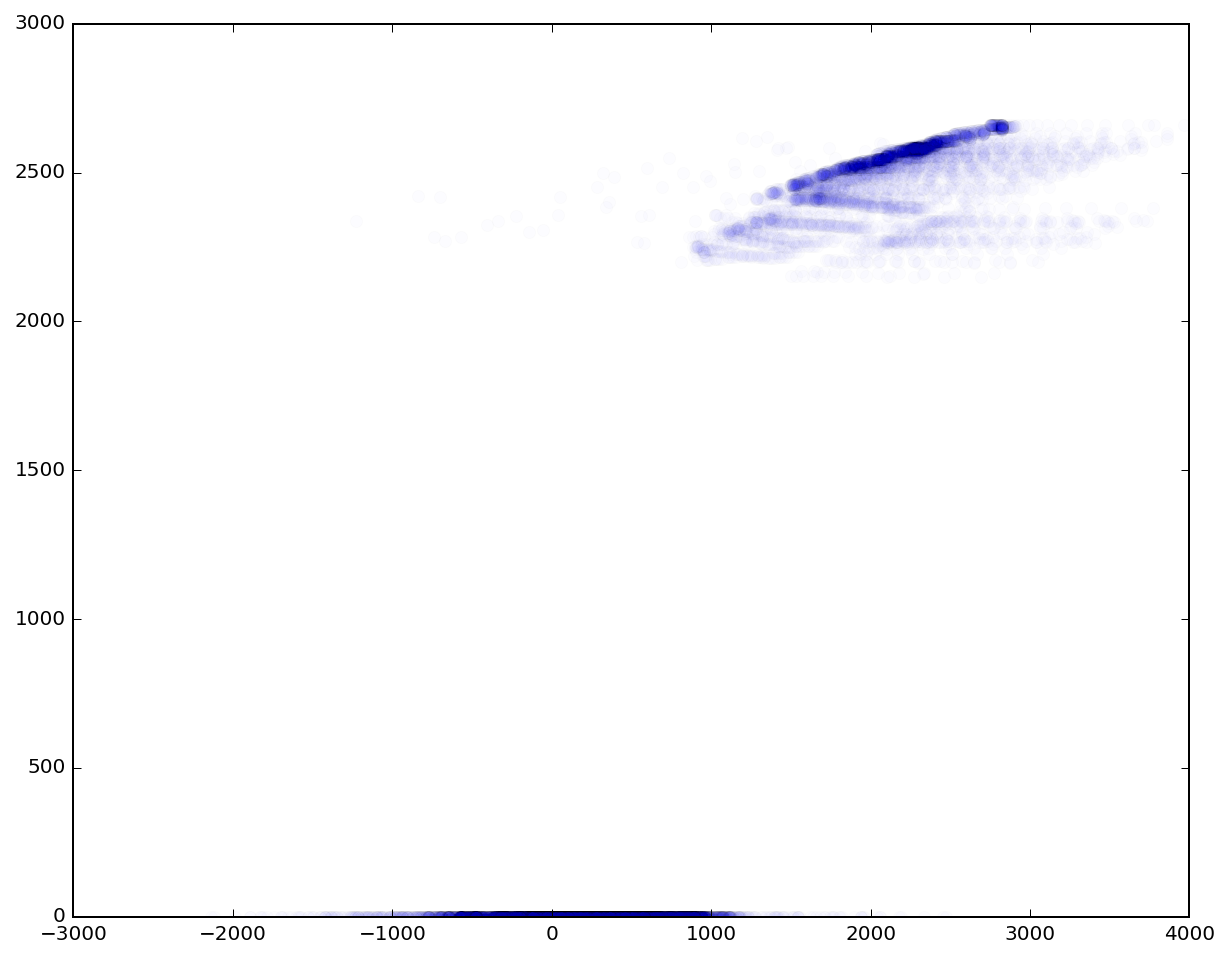

In [8]:
y_est = linmodel.predict(X)
plt.plot(y_est, y, 'o', alpha=0.01)

### Can we do better? 

In [9]:
import numpy as np
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

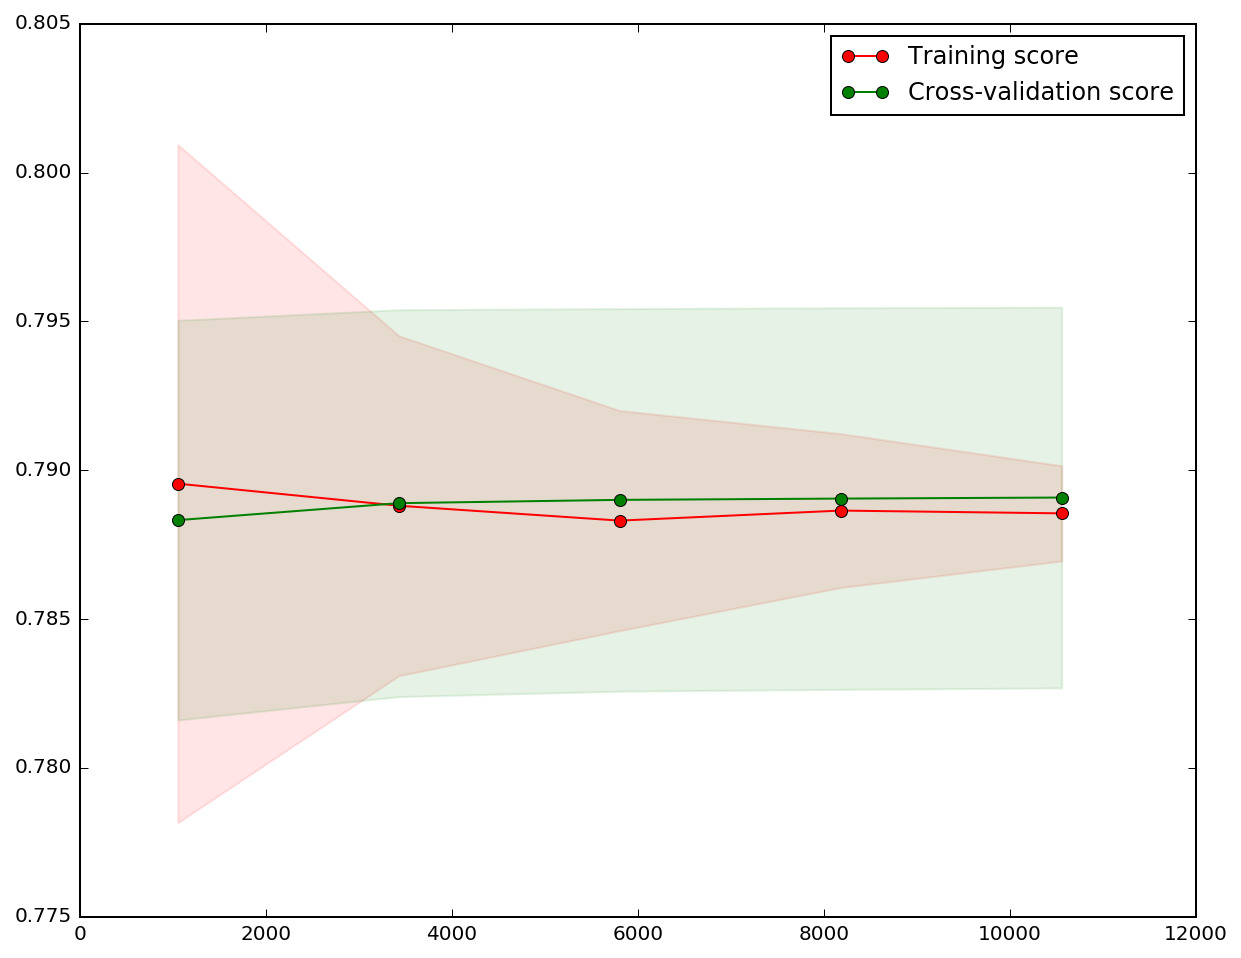

In [10]:
def plot_learning_curve(model, X, y):
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=100, test_size=0.2, random_state=0)

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=4)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    
plot_learning_curve(LinearRegression(normalize=True), X, y)

This tells us that our algorithm has a large **bias**, and adding additional data will not likely help.  The underlying model is simply not well modeled linearly.

We need a more complex model.

## Add complexity 

In [11]:
from sklearn.preprocessing import PolynomialFeatures

In [12]:
poly = PolynomialFeatures(2)
poly.fit_transform(X)
Xt = poly.fit_transform(X)
Xt.shape

(13201, 10)

In [13]:
poly = PolynomialFeatures(3)
poly.fit_transform(X)
Xt = poly.fit_transform(X)
Xt.shape

(13201, 20)

In [14]:
poly = PolynomialFeatures(4)
poly.fit_transform(X)
Xt = poly.fit_transform(X)
Xt.shape

(13201, 35)

In [15]:
def evaluate(model, degree=1):
    poly = PolynomialFeatures(degree)
    poly.fit_transform(X)
    Xt = poly.fit_transform(X)
    model.fit(Xt, y)
    return model.score(Xt, y)

for deg in [1,2,3,4,5]:
    print(evaluate(LinearRegression(normalize=True), degree=deg))

0.788690834619
0.834561169068
0.917561627122
0.927209339131
0.950422566383


We are getting a much better fit!

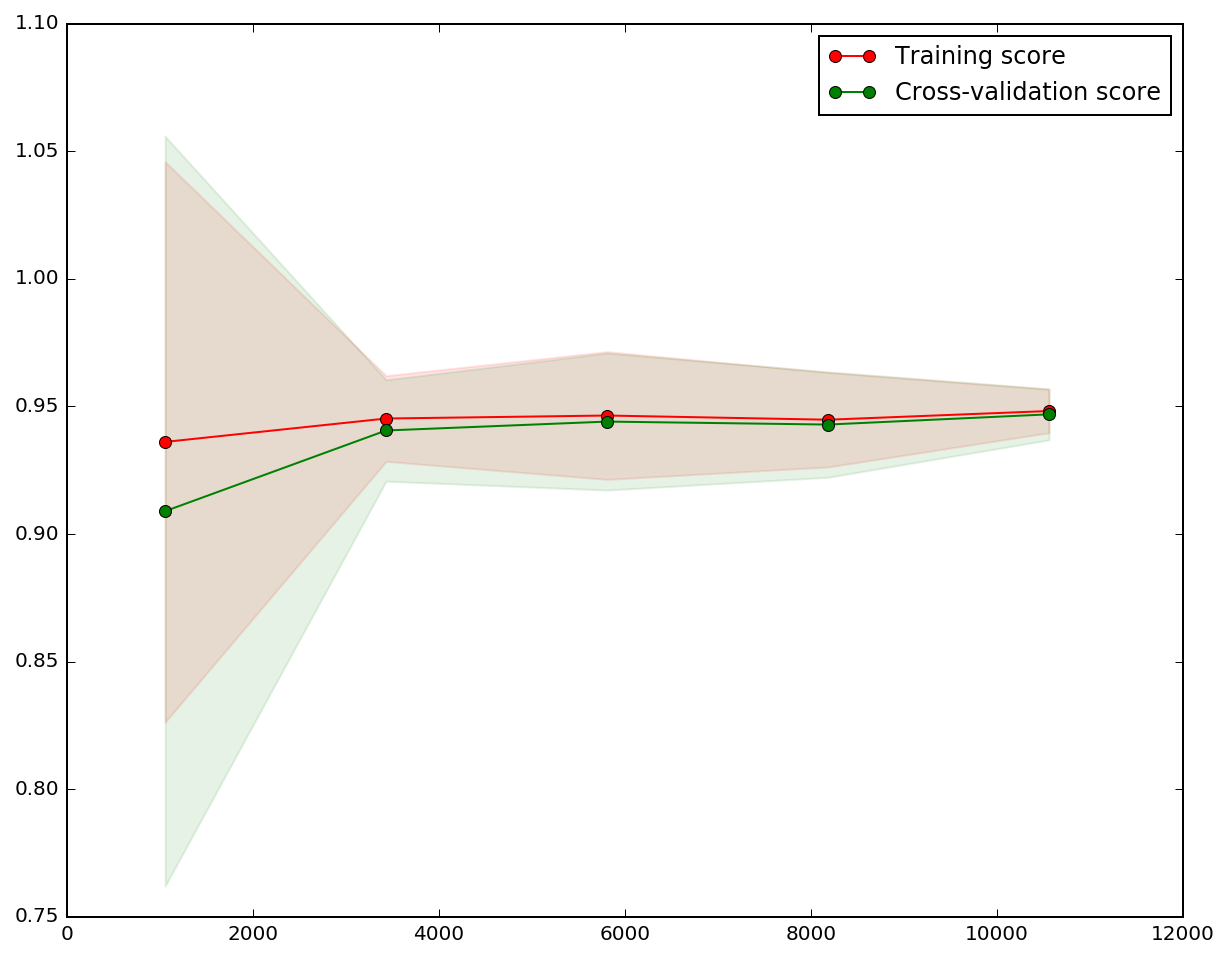

In [17]:
poly = PolynomialFeatures(5)
poly.fit_transform(X)
Xt = poly.fit_transform(X)
plot_learning_curve(LinearRegression(normalize=True), Xt, y)

Again, we have an improvement, but the model still has a bias.

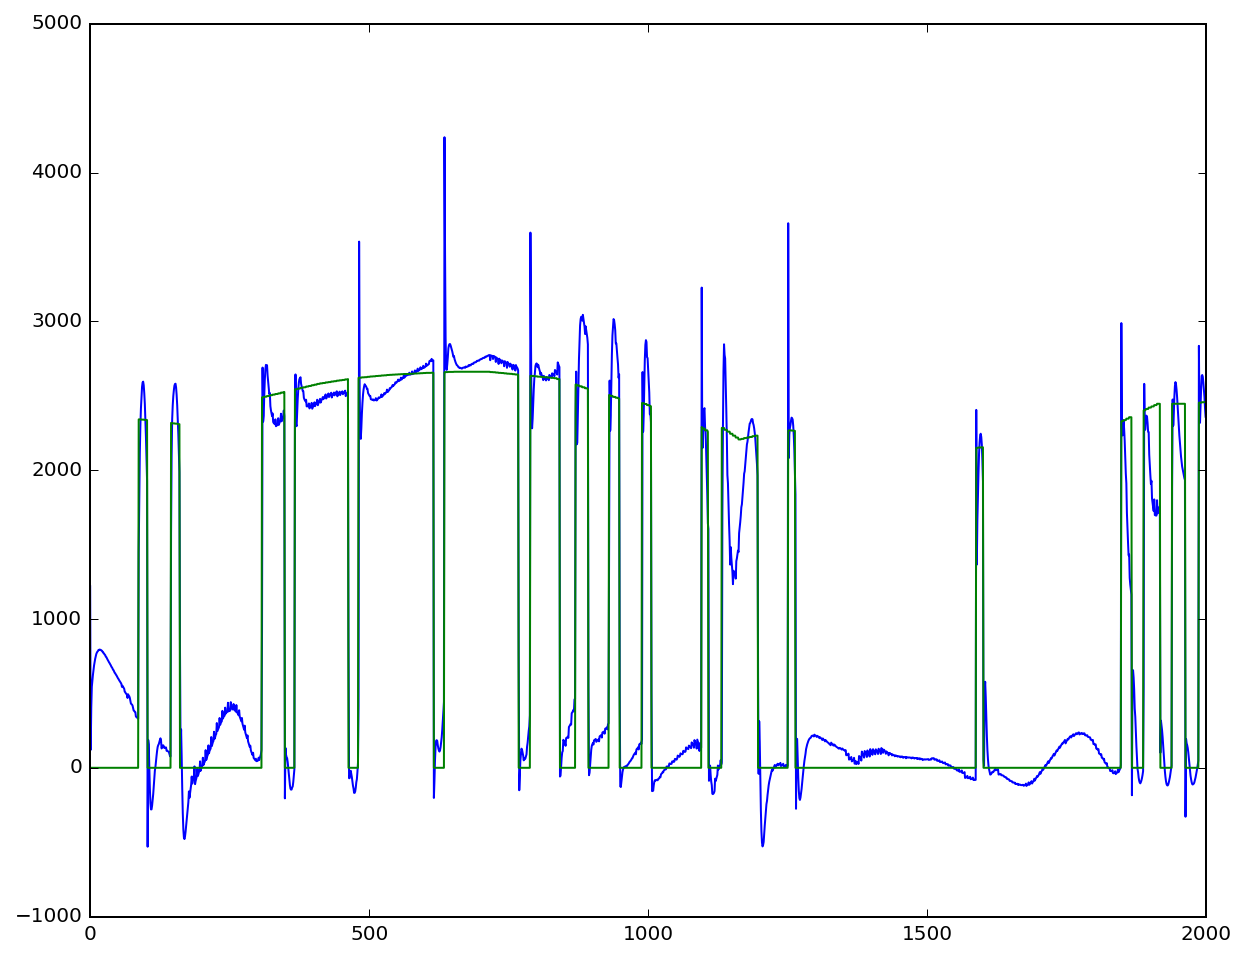

In [18]:
model = LinearRegression(normalize=True)
model.fit(Xt, y)
y_est = model.predict(Xt)

plt.plot(y_est[:2000])
plt.plot(y.values[:2000])

## What if this is better formed as a classification probelm?

The power is either on or off.

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
def categorize(y0):
    y = y0.copy()
    y[y<1500] = 0
    y[y>=1500] = 1
    return y

def evaluate_regression_model(clf, X, y0):
    y = categorize(y0)
    clf.fit(X, y)
    return clf.score(X, y)
    
logits = [ LogisticRegression(C=x) for x in [0.1, 1, 10, 100] ]

[ evaluate_regression_model(log, X, y) for log in logits ]

[0.86273767138853119,
 0.96136656313915614,
 0.9900007575183698,
 0.99613665631391557]

What does a day look like?

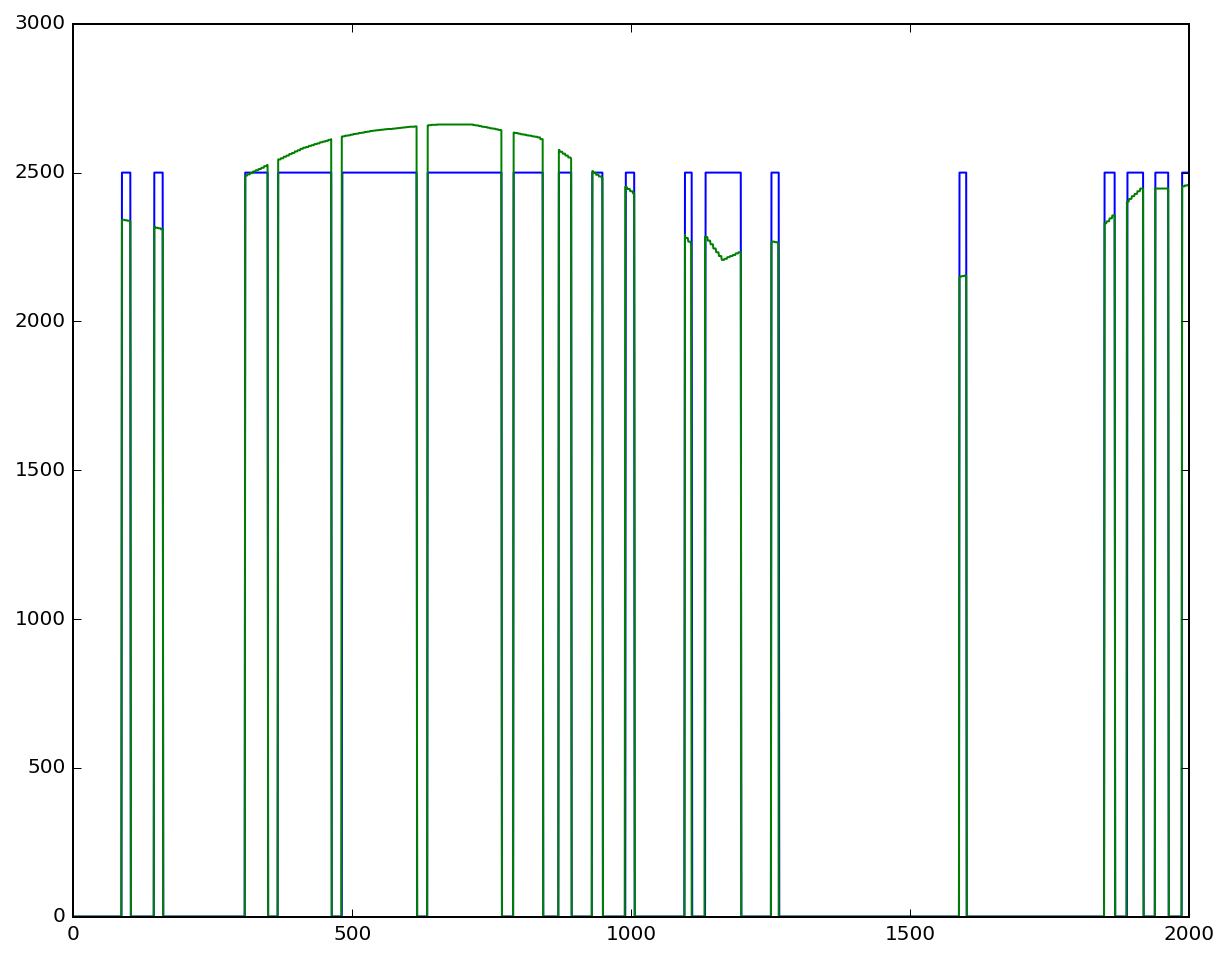

In [21]:
model = LogisticRegression(C=100)
yc = categorize(y)
model.fit(X, yc)
y_est = model.predict(X)

plt.plot(y_est[:2000]*2500)
plt.plot(y.values[:2000])